Load all required Libraries

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm 
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import tensorflow 

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Set the random seed in TensorFlow and NumPy; ensures the models can be reproduced

In [2]:
tensorflow.random.set_seed(42)
np.random.seed(42)

1. Set image size
2. Provide paths to Test and Train Data Images

In [3]:
image_width = 128
image_height = 128

path_test = "/home/user/Desktop/seismic-salt_classification/competition_data/test/"
path_train = "/home/user/Desktop/seismic-salt_classification/competition_data/train/"

In [4]:
# Get and resize train images and masks
def get_data(path, train=True):
    ids = next(os.walk(path + "images"))[2]
    X = np.zeros((len(ids), image_height, image_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), image_height, image_width, 1), dtype=np.float32)
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        # Load images
        x_img = img_to_array(load_img(path + '/images/' + id_, grayscale=True))
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=False))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)

  0%|          | 0/4000 [00:00<?, ?it/s]/home/user/anaconda3/lib/python3.7/site-packages/keras/utils/image_utils.py:410: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  'grayscale is deprecated. Please use color_mode = "grayscale"'
100%|██████████| 4000/4000 [00:11<00:00, 335.20it/s]


Split the training data with train_test_split() and validate

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

In [6]:
# This function creates 2 convolutional layers

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

Now implement the U-Net model

In [8]:
def UNet(input_image, n_filters=16, dropout=0.5, batchnorm=True):
    
    # Encoder
    c1 = conv2d_block(input_image, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # Decoder
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    
    return model

Load the input image and model

In [9]:
input_img = Input((image_height, image_width, 1), name='img')
model = UNet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

1. Defines the loss function, the optimizer and the metrics for the model.
2. Print a table of the layers of the model, the output shape of each layer and the number of parameters of each layer; the architecture of the model.

3. Functions to be applied at given stages of the training procedure.
4. Train the model; output to results.

In [11]:
# 1.
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

# 2.
model.summary()

# 3.
callbacks = [
    
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('./model/model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

# 4.
results = model.fit(X_train, y_train, batch_size=16, epochs=25, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 batch_normalization_8 (BatchNo  (None, 8, 8, 256)   1024        ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 8, 8, 256)    0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 8, 8, 256)    590080      ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 8, 8, 256)   1024        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
          

                                )                                 'activation_1[0][0]']           
                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  4624        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 128, 128, 16  64         ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
          

213/213 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.7351
Epoch 19: val_loss improved from 0.19259 to 0.18987, saving model to ./model/model-tgs-salt.h5
213/213 [==============================] - 82s 385ms/step - loss: 0.1871 - accuracy: 0.7351 - val_loss: 0.1899 - val_accuracy: 0.7676
Epoch 20/25
213/213 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.7344
Epoch 20: val_loss did not improve from 0.18987
213/213 [==============================] - 82s 384ms/step - loss: 0.1823 - accuracy: 0.7344 - val_loss: 0.1967 - val_accuracy: 0.7568
Epoch 21/25
213/213 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.7337
Epoch 21: val_loss did not improve from 0.18987
213/213 [==============================] - 82s 384ms/step - loss: 0.1901 - accuracy: 0.7337 - val_loss: 0.2330 - val_accuracy: 0.7236
Epoch 22/25
213/213 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.7356
Epoch 22: val_loss did not impr

Now plot the Learning Curve for the best model with its corresponding loss function and loss

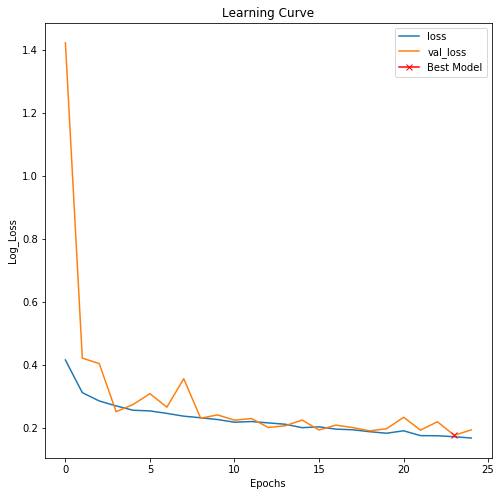

In [20]:
plt.figure(figsize=(8, 8))
plt.title("Learning Curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="Best Model")
plt.xlabel("Epochs")
plt.ylabel("Log_Loss")
plt.legend();

Once we get to around Epoch 8, the the predicted errors vs. the actual errors smooth out. That is, the accuracy/precision of the model improves. 

The best model is reached at Epoch 24, which isn't surprising; model performance improves with increasing number of Epochs. 

Now load the best model

In [22]:
model.load_weights('./model/model-tgs-salt.h5')

In [23]:
# Evaluate the validation set from the best model Log_Loss value; approx. 0.2

model.evaluate(X_valid, y_valid, verbose=1)



19/19 [==============================] - 5s 243ms/step - loss: 0.1757 - accuracy: 0.7734


[0.17574816942214966, 0.7733832001686096]

Now calculate the probabilities/predictions of the training and validation data set (from the best model)

In [24]:
# Predict on train, val and test
train_probabilities = model.predict(X_train, verbose=1)
validation_probabilities = model.predict(X_valid, verbose=1)

19/19 [==============================] - 5s 240ms/step


And the threshold predictions

In [25]:
train_predictions = (train_probabilities > 0.5).astype(np.uint8)
validation_predictions = (validation_probabilities > 0.5).astype(np.uint8)

Function for plotting sample data: seismic image, given label/mask, probabilities and predicted label/mask

In [26]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].set_title('Seismic image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Given Label')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Probabilities')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    ax[3].set_title('Predicted Label');

Call the plotting function to show some samples from the validation data set

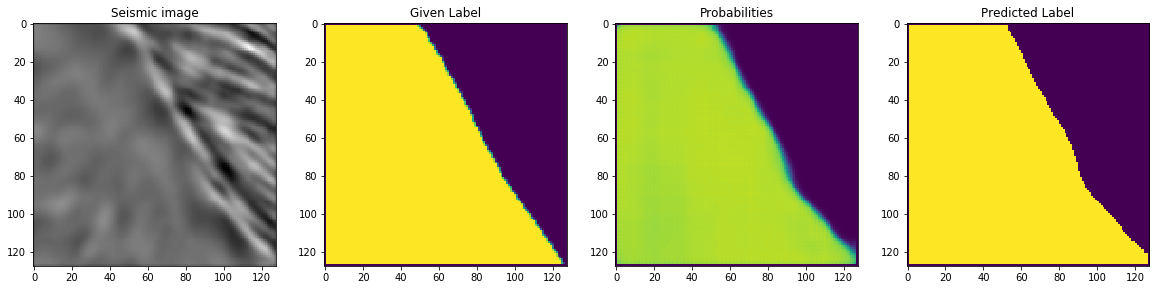

In [27]:
plot_sample(X_valid, y_valid, validation_probabilities, validation_predictions, ix=19)

The model does a pretty good job here, when comparing the Given Label to the Predicted Label. The actual seismic image shows a salt-like structure or a salt dome. From a geophysical interpretive perspective, the purple regions on the Given Label and Predicted Label show stratified layers, indicative of sedimentary layers, as can be seen on the seismic image. So the model has allowed us to distinguish between a salt dome and stratified sedimentary layers. 

And some more samples from the validation data set...

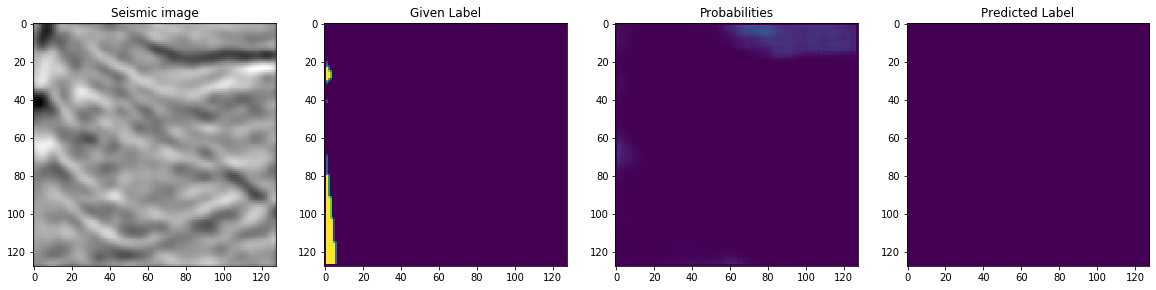

In [28]:
plot_sample(X_valid, y_valid, validation_probabilities, validation_predictions, ix=31)

This time, there is a bigger level of error present between the Predicted and the Given Labels. On the Given Label, there is a small section of salt present, which the model doesn't predict. However, the Predicted Label implies a that the structure is sediment and not salt. The seismic image shows this too due to there being some degree of stratification although not overly pronounced.